In [110]:
import pandas as pd
import numpy as np
import random as random

# plotly standard imports
import plotly.graph_objs as go
import plotly.plotly as py



In [111]:
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.figure_factory as ff


# Data input

In [112]:
input_df=pd.read_csv("train.csv", sep=",")
X=input_df.drop("revenue", axis=1) # drop labels for training set
y=input_df["revenue"]

In [113]:
type(y)

pandas.core.series.Series

In [114]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
type(y_train)

pandas.core.series.Series

In [117]:
X_train.reset_index(inplace=True);
X_test.reset_index(inplace=True);

In [118]:
df=pd.concat([X_train, y_train], axis=1, sort=False)

In [119]:
y_test=y_test.values
y_train=y_train.values

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 0 to 2998
Data columns (total 24 columns):
index                    2100 non-null float64
id                       2100 non-null float64
belongs_to_collection    425 non-null object
budget                   2100 non-null float64
genres                   2095 non-null object
homepage                 673 non-null object
imdb_id                  2100 non-null object
original_language        2100 non-null object
original_title           2100 non-null object
overview                 2092 non-null object
popularity               2100 non-null float64
poster_path              2099 non-null object
production_companies     1978 non-null object
production_countries     2059 non-null object
release_date             2100 non-null object
runtime                  2098 non-null float64
spoken_languages         2085 non-null object
status                   2100 non-null object
tagline                  1659 non-null object
title           

# Removing Nulls and Data exploration

In [121]:
X_train.isna().sum()

index                       0
id                          0
belongs_to_collection    1675
budget                      0
genres                      5
homepage                 1427
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      122
production_countries       41
release_date                0
runtime                     2
spoken_languages           15
status                      0
tagline                   441
title                       0
Keywords                  194
cast                        9
crew                       12
dtype: int64

In [122]:
from sklearn.base import TransformerMixin

In [123]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [124]:
X_train_t=DataFrameImputer().fit_transform(X_train)

In [125]:
df_t=DataFrameImputer().fit_transform(df)

In [126]:
X_train_t.isna().sum()

index                    0
id                       0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
Keywords                 0
cast                     0
crew                     0
dtype: int64

In [127]:
#Comparing correlatons between Consumption_per_NIA/log_NIA/Property Type 


figure = ff.create_scatterplotmatrix(
    df[['budget', 'popularity',"runtime","revenue"]],
    height=1000,
    width=1000,
    diag='histogram',
    title="Data Exploration")
iplot(figure)

In [128]:
corrs = df[["revenue","popularity","runtime","budget"]].corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

iplot(figure)

# Feature engineering

In [129]:
import ast


def cat_list(line):
    c_list=[]
    line_eval=ast.literal_eval(line)
    for d in line_eval:
        c_list.append(d["name"])
    return(c_list)

In [130]:
def get_left(string):
    try:
        if len(string)==8:
            return(int(string[:2]))
        else:
            return(int(string[:1]))
    except: return 0

In [131]:

def get_year(string):
    try:
        if int(string[-2:])< 20:
            return int(string[-2:])+2000
        else:
            return int(string[-2:])+1900
    except:
        return 0

In [132]:
X_train_t.head()

,index,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,611,612,"[{'id': 645, 'name': 'James Bond Collection', ...",8575000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://www.transformersmovie.com/,tt4016934,ko,아가씨,"1930s Korea, in the period of Japanese occupat...",...,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",6/1/16,145.0,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",Released,Never did they expect to get into a controvers...,The Handmaiden,"[{'id': 293, 'name': 'female nudity'}, {'id': ...","[{'cast_id': 3, 'character': 'Lady Hideko', 'c...","[{'credit_id': '54056d0b0e0a2658f100c167', 'de..."
1,530,531,"[{'id': 366444, 'name': 'Demetrius Filmreihe',...",4100000,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0046247,en,The Robe,Marcellus is a tribune in the time of Christ. ...,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",9/16/53,135.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The first motion picture in CinemaScope--the m...,The Robe,"[{'id': 3571, 'name': 'crucifixion'}, {'id': 5...","[{'cast_id': 1, 'character': 'Marcellus Gallio...","[{'credit_id': '52fe4603c3a368484e07be21', 'de..."
2,2787,2788,"[{'id': 645, 'name': 'James Bond Collection', ...",80000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.transformersmovie.com/,tt1037705,en,The Book of Eli,"A post-apocalyptic tale, in which a lone man f...",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1/14/10,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some will kill to have it. He will kill to pro...,The Book of Eli,"[{'id': 3096, 'name': 'book'}, {'id': 4458, 'n...","[{'cast_id': 1, 'character': 'Eli', 'credit_id...","[{'credit_id': '52fe43e9c3a368484e0058ad', 'de..."
3,49,50,"[{'id': 115570, 'name': 'Star Trek: The Next G...",38000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://www.transformersmovie.com/,tt0111280,en,Star Trek: Generations,Captain Jean-Luc Picard and the crew of the En...,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",11/17/94,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Boldly go.,Star Trek: Generations,"[{'id': 10988, 'name': 'based on tv series'}, ...","[{'cast_id': 5, 'character': 'Captain Jean-Luc...","[{'credit_id': '52fe4225c3a36847f80076c3', 'de..."
4,1883,1884,"[{'id': 454520, 'name': 'Captain Harlock Colle...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://www.transformersmovie.com/,tt2668134,ja,キャプテンハーロック,Space Pirate Captain Harlock and his fearless ...,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",9/7/13,115.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,"She's finally met her match. He's handsome, we...",Space Pirate Captain Harlock,"[{'id': 10183, 'name': 'independent film'}]","[{'cast_id': 1, 'character': 'Captain Harlock ...","[{'credit_id': '52fe4cac9251416c910fc711', 'de..."


In [133]:
from sklearn.preprocessing import StandardScaler

In [134]:
std_scaler=StandardScaler()

In [135]:
X_scaled=std_scaler.fit_transform(X_train_t[["budget","popularity"]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [136]:
X_scaled

array([[-0.35726586,  0.69030363],
       [-0.47588978, -0.37948385],
       [ 1.53607798,  0.49718858],
       ...,
       [-0.58457315, -0.05961715],
       [ 0.05162219, -0.34575116],
       [ 0.05162219, -0.34869796]])

In [137]:
from sklearn.base import BaseEstimator, TransformerMixin

In [138]:
df.columns

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [139]:

class DateAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        init
        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
       
        year=X['release_date'].apply(lambda x: get_year(x))
        df_year=pd.DataFrame(year.values,columns=["year"])
        month=X['release_date'].apply(lambda x:get_left(x))
        df_month=pd.DataFrame(month.values,columns=["month"])
       
        processed_X=pd.concat([X, df_year, df_month], axis=1, sort=False)
      
        return processed_X

In [140]:
attr_adder=DateAttributesAdder()
X_train_t2=attr_adder.fit_transform(X_train_t)

In [141]:
X_train_t2.columns

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'year',
       'month'],
      dtype='object')

# Unpacking categories and spoken languages

In [142]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
std_scaler=StandardScaler()

class CatAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        genres_list=X["genres"].apply(lambda x: cat_list(x))
        genres_label_data=mlb.fit_transform(genres_list)
        genres_labelClasses = mlb.classes_
        genresLabels=pd.DataFrame(genres_label_data, columns=genres_labelClasses)
        
        language_list=X['spoken_languages'].apply(lambda x: cat_list(x))
        language_label_data=mlb.fit_transform(language_list)
        language_labelClasses =  "spoken_lan_" + mlb.classes_
        languageLabels=pd.DataFrame(language_label_data, columns=language_labelClasses)
        languageLabels=languageLabels[[ 'spoken_lan_Deutsch', 'spoken_lan_English', 'spoken_lan_Español', 'spoken_lan_Français', 'spoken_lan_Italiano', 'spoken_lan_Pусский']]
        
        
        prod_country=X['production_countries'].apply(lambda x: cat_list(x))
        prod_country_label_data=mlb.fit_transform(prod_country)
        prod_country_labelClasses =  "prod_country_" + mlb.classes_
        prod_countryLabels=pd.DataFrame(prod_country_label_data, columns=prod_country_labelClasses)
        prod_countryLabels=prod_countryLabels[prod_countryLabels.columns[prod_countryLabels.sum()>len(X)/20]]
        
        
        prod_company=X['production_companies'].apply(lambda x: cat_list(x))
        prod_company_label_data=mlb.fit_transform(prod_company)
        prod_company_labelClasses = mlb.classes_
        prod_companyLabels=pd.DataFrame(prod_company_label_data, columns=prod_company_labelClasses)
        prod_companyLabels=prod_companyLabels[prod_companyLabels.columns[prod_companyLabels.sum()>len(X)/50]]
        
        org_lan_cat_1hot = cat_encoder.fit_transform(X[["original_language"]])
        df_org_lan=pd.DataFrame(org_lan_cat_1hot, columns=cat_encoder.categories_[0])
        df_org_lan=df_org_lan[df_org_lan.columns[df_org_lan.sum()>len(X)/100]]
        
        processed_X=pd.concat([X, genresLabels,languageLabels, prod_countryLabels, df_org_lan, prod_companyLabels], axis=1, sort=False)
        
         
        processed_X=processed_X[['budget',
                                   'popularity',
                                      'runtime',
                                       'Action',
                                    'Adventure',
                                    'Animation',
                                       'Comedy',
                                        'Crime',
                                  'Documentary',
                                        'Drama',
                                       'Family',
                                      'Fantasy',
                                      'Foreign',
                                      'History',
                                       'Horror',
                                        'Music',
                                      'Mystery',
                                      'Romance',
                              'Science Fiction',
                                     'Thriller',
                                          'War',
                                      'Western',
                           'spoken_lan_Deutsch',
                           'spoken_lan_English',
                           'spoken_lan_Español',
                          'spoken_lan_Français',
                          'spoken_lan_Italiano',
                           'spoken_lan_Pусский',
                          'prod_country_France',
                         'prod_country_Germany',
                  'prod_country_United Kingdom',
        'prod_country_United States of America',
                                        'en',
                                        'es',
                                        'fr',
                                        'hi',
                            'Columbia Pictures',
                    'Metro-Goldwyn-Mayer (MGM)',
                              'New Line Cinema',
                           'Paramount Pictures',
                          'Touchstone Pictures',
       'Twentieth Century Fox Film Corporation',
                           'Universal Pictures',
                                 'Warner Bros.', 
            "year", 
            "month"]]
        
        X["decade"]=(X["year"]-X["year"]%10)
        
        
        decade_cat_1hot = cat_encoder.fit_transform(X[["decade"]])
        df_year=pd.DataFrame(decade_cat_1hot, columns=cat_encoder.categories_[0])
        
        month_cat_1hot = cat_encoder.fit_transform(X[["month"]])
        df_month=pd.DataFrame(month_cat_1hot, columns=list(cat_encoder.categories_[0]))
        df_month.rename(columns={1: "Jan", 2: "Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Nov", 11:"Oct", 12:"Dec"}, inplace = True)

        processed_X["year_budget_ratio"]= processed_X["budget"]/((processed_X["year"])**2)
        
        processed_X=pd.concat([processed_X, df_month], axis=1, sort=False)
        
        processed_X=processed_X.drop(columns=["month"])
        return(processed_X)
        
        
     

In [143]:

attr_adder=CatAttributesAdder()
X_train_t3=attr_adder.fit_transform(X_train_t2)

In [144]:
X_train_t3.columns

Index(['budget', 'popularity', 'runtime', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'Thriller', 'War', 'Western', 'spoken_lan_Deutsch',
       'spoken_lan_English', 'spoken_lan_Español', 'spoken_lan_Français',
       'spoken_lan_Italiano', 'spoken_lan_Pусский', 'prod_country_France',
       'prod_country_Germany', 'prod_country_United Kingdom',
       'prod_country_United States of America', 'en', 'es', 'fr', 'hi',
       'Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema',
       'Paramount Pictures', 'Touchstone Pictures',
       'Twentieth Century Fox Film Corporation', 'Universal Pictures',
       'Warner Bros.', 'year', 'year_budget_ratio', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Nov', 'Oct', 'Dec'],
      dtype='object')

In [145]:
X_train_t3.head()

,budget,popularity,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Nov,Oct,Dec
0,8575000,16.727405,145.0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4100000,3.826281,135.0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,80000000,14.398530,118.0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38000000,8.105708,118.0,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,30000000,7.857666,115.0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Preparation Pipeline

In [146]:
from sklearn.preprocessing import PolynomialFeatures
Poly_Feat=PolynomialFeatures(degree=2, include_bias=False)

class PolyAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        init
        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_num=X[["budget","runtime","popularity","year"]]
        X_num["year"]=X_num.year-1900
        X_poly=Poly_Feat.fit_transform(X_num)
        poly_columns=[]
        for col in Poly_Feat.get_feature_names():
            col=str(col).replace("x0","budget")
            col=str(col).replace("x1","runtime")
            col=str(col).replace("x2","popularity")
            col=str(col).replace("x3","year")
            poly_columns.append(col)

        
        df_poly=pd.DataFrame(X_poly, columns=poly_columns)
        df_poly.drop(["budget","runtime","popularity"], axis=1, inplace=True)
        processed_X=pd.concat([X, df_poly], axis=1, sort=False)
    
        return processed_X
  

In [147]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_atrribs=[["budget_scaled", "runtime_scaled","popularity_scaled","year_scaled"]]

polynomial_pipeline = Pipeline([
    ("imputer", DataFrameImputer()),
    ("date_adder", DateAttributesAdder()),
    ("cat_adder", CatAttributesAdder()),
    ("polynomial_adder", PolyAttributesAdder(),)
    ])

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preparation_pipeline = Pipeline([
    ("imputer", DataFrameImputer()),
    ("date_adder", DateAttributesAdder()),
    ("cat_adder", CatAttributesAdder()),
    ("polynomial_adder", PolyAttributesAdder(),)

    ])

In [149]:
preparation_pipeline=preparation_pipeline.fit(X_train)

In [150]:
X_train_prep=preparation_pipeline.transform(X_train)

In [151]:
len(X_train_prep)

2100

In [152]:
X_test_prep=preparation_pipeline.transform(X_test)

In [153]:
X_test_prep.shape

(900, 69)

# Linear regression

In [154]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [155]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(10, len(X_train),50):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size (*50)", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

In [156]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prep, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [157]:
from sklearn.metrics import mean_squared_error

reve_pred=lin_reg.predict(X_test_prep)
lin_mse = mean_squared_error(reve_pred, y_test)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

79251900.26331727

In [158]:
lin_reg.score(X_test_prep, y_test)

0.6035849394950986

In [159]:
reve_pred=lin_reg.predict(X_train_prep)
lin_mse = mean_squared_error(reve_pred, y_train)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

83728795.58810881

In [160]:
lin_reg.score(X_train_prep, y_train)

0.6533021725737775

[0, 40, 0, 100000000]

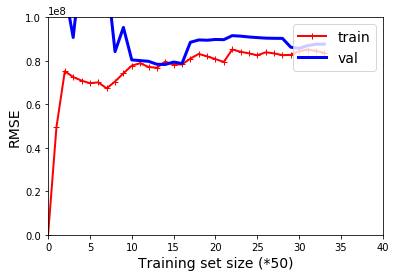

In [161]:
plot_learning_curves(lin_reg, X_train_prep.values, y_train)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show()                                      # not shown

Clear Linear regression seems to underfit the data

# Random Forest

In [162]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train_prep, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [163]:
reve_pred=forest_reg.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

78462078.6808141

In [164]:
rfr_rmse/y_test.mean()

1.1493138485570118

In [165]:
forest_reg.score(X_test_prep, y_test)

0.6114468837972891

In [166]:
forest_reg.score(X_train_prep, y_train)

0.9340047008553934

In [167]:
from sklearn.model_selection import GridSearchCV

In [168]:
param_grid = [
    {'n_estimators':[30,90,270], "max_features":[8,16,24],"min_samples_leaf":[9,27], "max_depth":[9,15,20]},
    
    {"bootstrap":[True], "n_estimators":[90,270],"min_samples_leaf":[9,27],"max_features":[4,8,16],"max_depth":[9,15,20]},
    
    {"bootstrap":[False], "n_estimators":[90,270],"min_samples_leaf":[9,27],"max_features":[4,8,16], "max_depth":[9,15,20]},
    
]

In [169]:
forest_reg=RandomForestRegressor (random_state=10)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [30, 90, 270], 'max_features': [8, 16, 24], 'min_samples_leaf': [9, 27], 'max_depth': [9, 15, 20]}, {'bootstrap': [True], 'n_estimators': [90, 270], 'min_samples_leaf': [9, 27], 'max_features': [4, 8, 16], 'max_depth': [9, 15, 20]}, {'bootstrap': [False], 'n_estimators': [90, 270], 'min_samples_leaf': [9, 27], 'max_features': [4, 8, 16], 'max_depth': [9, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_

In [170]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 8,
 'min_samples_leaf': 9,
 'n_estimators': 90}

In [171]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(np.sqrt(-mean_score)/1000000), params)

85.0 {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 30}
85.0 {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 90}
84.0 {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 270}
93.0 {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 27, 'n_estimators': 30}
92.0 {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 27, 'n_estimators': 90}
92.0 {'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 27, 'n_estimators': 270}
84.0 {'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 9, 'n_estimators': 30}
84.0 {'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 9, 'n_estimators': 90}
84.0 {'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 9, 'n_estimators': 270}
91.0 {'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 27, 'n_estimators': 30}
91.0 {'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 27, 'n_estimators': 90}
91.0 {'max_depth': 9, 'max_features': 16, 'min_samples_leaf': 2

In [172]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances;
attributes = X_train_prep.columns
sorted(zip(feature_importances, attributes), reverse=True)

array([1.56610711e-01, 4.34786385e-02, 1.17956093e-02, 3.30184335e-03,
       8.70599546e-03, 2.92205286e-03, 8.29449530e-04, 3.91945310e-04,
       4.06340353e-05, 4.74743155e-03, 4.32278166e-03, 1.94735231e-03,
       0.00000000e+00, 2.26436927e-04, 3.47493430e-04, 0.00000000e+00,
       2.54085924e-05, 8.99479615e-04, 6.51192078e-04, 8.30952288e-04,
       4.21551675e-05, 0.00000000e+00, 6.50992616e-06, 7.58018426e-04,
       4.06352776e-06, 7.42718333e-05, 4.12658308e-07, 1.62583175e-04,
       4.40086621e-05, 5.74578535e-05, 1.20669717e-04, 2.56636003e-03,
       3.92084084e-04, 0.00000000e+00, 1.55191853e-05, 1.56263910e-06,
       3.01024128e-05, 5.38907065e-06, 8.50035396e-05, 1.83470798e-04,
       1.13712263e-05, 2.42918061e-04, 2.90915865e-04, 3.19421275e-04,
       4.08714311e-03, 1.09065675e-01, 8.92331176e-05, 2.57509854e-05,
       5.91682991e-05, 6.93924928e-05, 5.26014811e-04, 1.59182179e-03,
       1.03864141e-04, 6.72188323e-05, 6.98298245e-05, 1.34677270e-04,
      

[(0.17995084276778314, 'budget popularity'),
 (0.15661071126774867, 'budget'),
 (0.12307315150030428, 'budget year'),
 (0.10906567486680295, 'year_budget_ratio'),
 (0.09276274056324346, 'budget runtime'),
 (0.08051615919112286, 'budget^2'),
 (0.05013743545599261, 'popularity^2'),
 (0.043478638513663875, 'popularity'),
 (0.03584428010043616, 'popularity year'),
 (0.03532443663239207, 'runtime popularity'),
 (0.016109983689476984, 'runtime year'),
 (0.012957075462799356, 'runtime^2'),
 (0.011795609294682347, 'runtime'),
 (0.008705995458065507, 'Adventure'),
 (0.004974953630222534, 'year'),
 (0.0047474315542225965, 'Drama'),
 (0.004743887240383532, 'year^2'),
 (0.00432278166446147, 'Family'),
 (0.0040871431149182465, 'year'),
 (0.0033018433455424307, 'Action'),
 (0.0029220528630399508, 'Animation'),
 (0.0025663600296362203, 'prod_country_United States of America'),
 (0.0019473523074397376, 'Fantasy'),
 (0.0015918217881179858, 'Jun'),
 (0.000899479614580278, 'Romance'),
 (0.000830952287809

In [173]:
final_model = grid_search.best_estimator_

In [174]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=15,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=9,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=None, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [175]:
reve_pred_fin=final_model.predict(X_test_prep)
fin_mse = mean_squared_error(reve_pred_fin, y_test)
fin_rmse=np.sqrt(fin_mse)
fin_rmse

71734523.85584694

In [176]:
fin_rmse/y_test.mean()

1.0507685122969876

In [177]:
reve_pred_fin=final_model.predict(X_train_prep)
fin_mse = mean_squared_error(np.log1p(reve_pred_fin), np.log1p(y_train))
fin_rmse=np.sqrt(fin_mse)
fin_rmse

2.5727334682389436

In [178]:
final_pred=pd.Series(final_model.predict(X_test_prep))

In [179]:
final_model.score(X_test_prep, y_test)

0.6752215408316419

[0, 40, 0, 100000000]

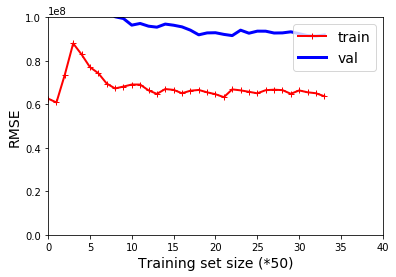

In [180]:
plot_learning_curves(final_model, X_train_prep.values, y_train)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show()             

While RandomForestsRegressor significantly overfits

# Lgb

In [181]:
import lightgbm as lgb
random_seed=42

In [182]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=5, 
                             min_child_samples=100,
                             learning_rate=0.001,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.2,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random_seed, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [183]:
lgbmodel.fit(X_train_prep, y_train)

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=42,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.9, feature_fraction=0.2, importance_type='gain',
       lambda_l1=0.2, learning_rate=0.001, max_depth=5, metric='rmse',
       min_child_samples=100, min_child_weight=0.001, min_data_in_leaf=10,
       min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=5,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0, use_best_model=True)

In [184]:
lgbmodel.score(X_test_prep, y_test)

0.6789175357484888

In [185]:
reve_pred=lgbmodel.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

71325184.73536831

In [186]:
rfr_rmse/y_test.mean()

1.0447725059735242

[0, 40, 0, 100000000]

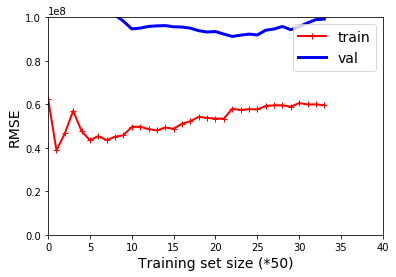

In [187]:
plot_learning_curves(lgbmodel, X_train_prep.values, y_train)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show()    

# Gradient Boosting

In [188]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=1.0, random_state=42)


In [189]:
gbrt.fit(X_train_prep, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [190]:
param_grid = [
    {'n_estimators':[30,90], "max_features":[4,6,8,16],"min_samples_leaf":[3,9,27], "max_depth":[9,15,20]},
 
]

In [191]:
gbrt=GradientBoostingRegressor(random_state=10)

grid_search = GridSearchCV(gbrt, param_grid, cv=5,
                          scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=10, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [30, 90], 'max_features': [4, 6, 8, 16], 'min_samples_leaf': [3, 9, 27], 'max_depth': [9, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [192]:
grid_search.best_params_

{'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 9, 'n_estimators': 90}

In [193]:
gbrt = grid_search.best_estimator_

In [194]:
reve_pred=gbrt.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

70525108.0545044

In [195]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances;
attributes = X_train_prep.columns;
sorted(zip(feature_importances, attributes), reverse=True)

array([3.28690160e-02, 1.35025163e-01, 1.10323772e-02, 4.80110071e-03,
       1.11666097e-02, 6.07420470e-03, 1.55024387e-03, 9.34244693e-04,
       8.32370000e-04, 5.83956293e-03, 4.75738485e-03, 1.58879030e-03,
       2.66782959e-06, 1.09413546e-03, 7.86059715e-04, 1.73549891e-04,
       2.10996272e-04, 2.64076726e-03, 1.14818928e-03, 3.14010274e-03,
       7.81094683e-04, 1.02361047e-04, 9.23346773e-05, 3.09166144e-03,
       1.90510818e-04, 3.57789301e-04, 8.27987831e-05, 1.52498342e-04,
       6.03140869e-04, 9.65987689e-04, 3.49917744e-04, 4.88237934e-03,
       3.70070038e-04, 6.41401654e-07, 7.89212989e-05, 3.18981348e-05,
       7.24558328e-05, 4.38254699e-05, 5.97598969e-04, 7.41739329e-04,
       8.10143439e-05, 8.56898165e-05, 8.75087211e-04, 2.21010240e-03,
       7.90672094e-03, 1.48120745e-01, 2.07624298e-04, 4.91924006e-04,
       2.88548210e-04, 2.19021081e-04, 9.60256711e-04, 4.75172503e-03,
       4.60326798e-04, 6.94388933e-04, 3.82417357e-04, 5.27902676e-04,
      

[(0.14812074482318535, 'year_budget_ratio'),
 (0.14624790808898727, 'budget runtime'),
 (0.13502516317536095, 'popularity'),
 (0.10150363764021644, 'budget^2'),
 (0.09697440495390401, 'budget year'),
 (0.05555145453079712, 'budget popularity'),
 (0.044068683599351455, 'popularity^2'),
 (0.04276642108390224, 'popularity year'),
 (0.04198124717353181, 'runtime popularity'),
 (0.0328690159948881, 'budget'),
 (0.025990922401339593, 'runtime year'),
 (0.01602114891781391, 'year^2'),
 (0.011166609688828348, 'Adventure'),
 (0.01103237718342487, 'runtime'),
 (0.011025990100055578, 'runtime^2'),
 (0.008980230184394217, 'year'),
 (0.007906720940989185, 'year'),
 (0.006074204698561339, 'Animation'),
 (0.005839562933343931, 'Drama'),
 (0.004882379337643268, 'prod_country_United States of America'),
 (0.004801100712829662, 'Action'),
 (0.004757384851694957, 'Family'),
 (0.004751725030294204, 'Jun'),
 (0.0031401027439616667, 'Thriller'),
 (0.0030916614367185666, 'spoken_lan_English'),
 (0.0026407672

In [207]:
gbrt.score(X_test_prep, y_test)

0.6639448532801694

[0, 40, 0, 100000000]

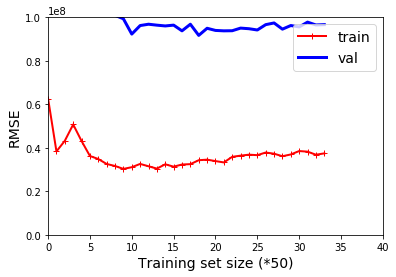

In [208]:
plot_learning_curves(gbrt, X_train_prep.values, y_train)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show() 

# AdaBoostRegressor

In [198]:
from sklearn.ensemble import AdaBoostRegressor

In [199]:
ada_reg=AdaBoostRegressor()

In [200]:
param_grid = [
    {'n_estimators':[10,30,90], "learning_rate":[0.03,0.1,0.5],"loss":["linear","square","exponential"]},
 
]

In [201]:
ada_reg=AdaBoostRegressor(random_state=10)

grid_search = GridSearchCV(ada_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=10),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 30, 90], 'learning_rate': [0.03, 0.1, 0.5], 'loss': ['linear', 'square', 'exponential']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [202]:
grid_search.best_params_

{'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 30}

In [203]:
ada_reg = grid_search.best_estimator_

In [204]:
reve_pred=ada_reg.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

79145930.71289429

In [205]:
ada_reg.score(X_test_prep, y_test)

0.6046443422530932

[0, 40, 0, 100000000]

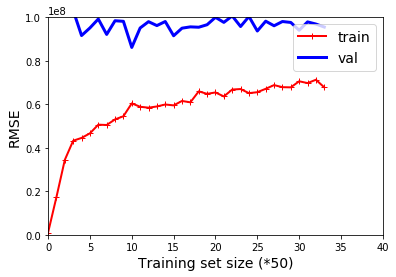

In [206]:
plot_learning_curves(ada_reg, X_train_prep.values, y_train)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show() 